## Set parameters for the experiment

In [1]:
# %%writefile param_sets.json

seed_value = 123  # seed for the experiment
Trial = 4  # number of the experiment


period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'orh', 'sat-oat', 'wbt']  # input predictors
x_loc = [0, 1, 2, 3]  # input vars we want to plot in detailed plot
outputcols = ['hwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + 'hwevalve' + '_model_{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

# Smoothing
smooth_data = True  # whetter to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = False  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['hwe']  # create sum aggregate for these columns
rolling_mean_target = ['sat-oat', 'wbt', 'orh', 'oat']  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

# Values below which we consider as 0 output in hwe 
# units is kBTU in period*5 mins
threshold = 0.5

# Custom way to create Training Data
startweek = 0  # start week; indicates how large training set is
data_weeks = 39  # Create a large initial block startweek-data_weeks weeks of training and testing data
end_week = -1
feature_range = (0, 1)  # Scaling range
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 8,
    'lstm_no_layers': 2,
    'dense_hidden_units': 16,
    'dense_no_layers': 4,
    'retrain_from_layers': 3,
    'train_stateful': False,
    'test_stateful':False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = True  # reinitialize the weights of certain layers
reinitialize = True  # reinitialize the weights of certain layer

model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/buildingdata.pkl'

# additional info
addl = {
    'metainfo': 'create a diff of sat and oat for hot water energy prediction as it is useful. See 1.0.8',
    'names_abreviation': {
        'oat':'Outside Air Temperature',
        'orh':'Outside Air Relative Humidity',
        'sat-oat' : 'Difference of Supply Air and Outside Air Temps ',
        'ghi': 'Global Solar Irradiance',
        'hw_sf':'Hot Water System Flow Rate',
        'hx_vlv1':'Hot Water Valve %',
        'hw_st':'Hot Water Supply Temperature',
        'hx_vlv1*hw_sf': 'Hot Water Flow Valve Opening',
        'wbt': 'Wet Builb Temperature',
        'on_off':'On-Off state of valve'
    }
}
x_lab = [addl['names_abreviation'][inputcols[i]] for i in x_loc]

## Set Seed in numpy, Keras and TF for reproducability and Import modules

In [2]:
import shutil
import glob
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num
import matplotlib.pyplot as plt

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
    from keras.utils import to_categorical

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


## Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')
os.mkdir(path + 'detailedplots')

## Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'x_loc': x_loc,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'threshold': threshold,
    
    'startweek': startweek,
    'data_weeks' : data_weeks,
    'end_week':end_week,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    'addl' : addl,
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

## Read the cleaned data

In [6]:
# read the pickled file for ahu data
df1data = dp.readfile(datapath)

# return pickled df
df1 = df1data.return_df(processmethods=['file2df'])

In [7]:
# read the pickled file for ahu data
df2data = dp.readfile('../data/processed/interpolated/wetbulbtemp.pkl')

# return pickled df
df2 = df2data.return_df(processmethods=['file2df'])

In [8]:
df = dp.merge_df_columns([df1,df2])

## Create additional Data columns as needed

In [9]:
df['sat-oat']= df['sat']-df['oat']
df.head()

,oat,sat,sat_stpt,orh,hwe,cwe,ghi,avg_stpt,flow,hw_rt,hw_sf,hw_st,hw_s_stp,hx_vlv1,wbt,sat-oat
2018-07-13 07:50:00,80.913567,79.320808,65.0,82.0,0.0,32.546185,562.0,69.52381,39.534317,89.589584,0.0,94.427994,90.0,0.276543,76.486129,-1.592758
2018-07-13 07:55:00,80.913567,79.023285,65.0,82.0,0.0,29.293947,580.0,69.52381,39.809956,89.589584,0.0,94.125771,90.0,0.276543,76.486129,-1.890282
2018-07-13 08:00:00,80.615402,79.023285,65.0,82.0,0.0,30.685425,597.0,69.52381,39.174774,89.589584,0.0,94.125771,90.0,0.276543,76.203297,-1.592117
2018-07-13 08:05:00,80.303123,79.023285,65.0,82.0,0.0,30.074446,614.0,69.52381,35.745533,89.229790,0.0,93.816162,90.0,0.276543,75.907098,-1.279839
2018-07-13 08:10:00,80.303123,79.023285,65.0,79.0,0.0,29.646845,625.0,69.52381,34.858036,89.229790,0.0,93.816162,90.0,0.276543,75.132472,-1.279839


## Smooth the data

In [10]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

## Remove <0 values for output energy

In [11]:
# df['hw_sf'][df['hw_sf']<=0]=0
# df['hx_vlv1'][df['hx_vlv1']<=0]=0
# df['hx_vlv1*hw_sf']=df['hx_vlv1']*df['hw_sf']
df['hwe'][df['hwe']<=0]=0.001

## Adjust lag for certain columns if needed

In [12]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

## Create aggregate data: aggregate specified columns at specified intervals

In [13]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    if rolling_sum_target:
        df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    if rolling_mean_target:
        df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

In [14]:
# show data
df.describe()

,oat,sat,sat_stpt,orh,hwe,cwe,ghi,avg_stpt,flow,hw_rt,hw_sf,hw_st,hw_s_stp,hx_vlv1,wbt,sat-oat
count,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000,21972.000000
mean,63.626459,70.279768,71.527193,60.052646,20.669582,22.973918,172.942062,71.543962,37.363495,91.814716,8.735500,101.210640,101.229989,25.112043,55.037774,6.652807
std,17.449652,5.522686,2.912892,17.309789,24.973755,17.184860,256.253086,1.049011,30.230656,13.202156,9.362582,14.166112,14.217698,19.757493,14.706875,17.865582
min,17.821972,51.414037,58.605072,17.309428,0.000000,-3.155953,-52.457182,66.099812,-1.813372,64.903137,-3.199521,80.075723,87.778581,-6.725714,14.846887,-25.245728
25%,49.122695,67.350715,72.985144,46.643152,0.347442,6.786246,-0.008553,70.895254,9.579149,82.487488,0.153180,90.170202,90.000000,8.601981,42.724516,-6.342488
50%,65.802556,71.941023,73.000000,59.389406,12.055460,21.379774,14.525874,71.342910,32.582537,87.654030,5.767948,93.361092,91.826296,24.089376,57.819468,2.493956
75%,77.806590,73.671579,73.000000,74.189186,29.208939,38.433393,284.137952,72.485714,63.573265,98.311284,13.121553,112.273139,112.210568,42.576567,68.115115,23.150072
max,97.319737,90.015817,74.044062,95.007589,159.757820,66.524093,973.479051,73.557921,125.398265,135.552460,32.572670,147.479417,148.331329,73.261725,85.891934,55.312001


## Get mean of the entire data

In [15]:
# get the mean of the outputs for the entire data
threshold_scaled = ((threshold - df.min()['hwe']) /
                    (df.max()['hwe'] - df.min()['hwe']))

## Create temporal chunks of data

In [16]:
# Creating a list of "days" days dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 76


## Custom way to create Weekly Training and Testing Data

In [17]:
from pandas import concat, Timedelta

def quickmerge(listdf):
    return concat(listdf)

weeklist = []  # create list of training, testing arrays

In [18]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[startweek:data_weeks-1]
#merge them together
minibatch_train = quickmerge(datablock_train_pre)

# select weeks=1 worth of data
minibatch_test = dflist[data_weeks-1]

# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index

# year and week
yearno = minibatch_test.index[int(splitvalue/2)].year
weekno = minibatch_test.index[int(splitvalue/2)].week

# threshold train and test Y's to 0 and 1
y_train_thresh = np.zeros_like(y_train)
y_train_thresh[:,:,0][y_train[:,:,0]>=threshold_scaled]=1
y_train_thresh = to_categorical(y_train_thresh)
y_test_thresh = np.zeros_like(y_test)
y_test_thresh[:,:,0][y_test[:,:,0]>=threshold_scaled]=1
y_test_thresh = to_categorical(y_test_thresh)

# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(yearno), 
                                      str(weekno)),
        'X_train':X_train,
        'y_train': [y_train,y_train_thresh],
        'X_test': X_test,
        'y_test': [y_test,y_test_thresh],
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

In [19]:
for weekdata in dflist[data_weeks:]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[minibatch_test]
    #merge them together
    minibatch_train = quickmerge(datablock_train_pre)
    
    # select weeks=1 worth of data
    minibatch_test = weekdata
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index
    
    # year and week no
    weekno += 1
    weekno = weekno if weekno%53 != 0 else 1
    yearno = yearno if weekno!= 1 else yearno+1
    
    # threshold train and test Y's to 0 and 1
    y_train_thresh = np.zeros_like(y_train)
    y_train_thresh[:,:,0][y_train[:,:,0]>=threshold_scaled]=1
    y_train_thresh = to_categorical(y_train_thresh)
    y_test_thresh = np.zeros_like(y_test)
    y_test_thresh[:,:,0][y_test[:,:,0]>=threshold_scaled]=1
    y_test_thresh = to_categorical(y_test_thresh)

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(yearno), 
                                      str(weekno)),
        'X_train':X_train,
        'y_train': [y_train,y_train_thresh],
        'X_test': X_test,
        'y_test': [y_test,y_test_thresh],
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 38


### Print size and shape of data to feed to the LSTM for sanity checks

In [20]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            if isinstance(value,list):
                for i in value:
                    print("name: {}, shape: {}".format(key, i.shape))
            else:
                print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-16
name: X_train, shape: (11212, 1, 4)
name: y_train, shape: (11212, 1, 1)
name: y_train, shape: (11212, 1, 2)
name: X_test, shape: (321, 1, 4)
name: y_test, shape: (321, 1, 1)
name: y_test, shape: (321, 1, 2)
name: test_idx, shape: (321,)
name: Id, shape: Year-2019-Week-17
name: X_train, shape: (11221, 1, 4)
name: y_train, shape: (11221, 1, 1)
name: y_train, shape: (11221, 1, 2)
name: X_test, shape: (316, 1, 4)
name: y_test, shape: (316, 1, 1)
name: y_test, shape: (316, 1, 2)
name: test_idx, shape: (316,)
name: Id, shape: Year-2019-Week-18
name: X_train, shape: (11205, 1, 4)
name: y_train, shape: (11205, 1, 1)
name: y_train, shape: (11205, 1, 2)
name: X_test, shape: (312, 1, 4)
name: y_test, shape: (312, 1, 1)
name: y_test, shape: (312, 1, 2)
name: test_idx, shape: (312,)
name: Id, shape: Year-2019-Week-19
name: X_train, shape: (11188, 1, 4)
name: y_train, shape: (11188, 1, 1)
name: y_train, shape: (11188, 1, 2)
name: X_test, shape: (314, 1, 4)
name: y_

### Add weekly train test data to modelconfig dictionary for ease of training

In [21]:
modelconfig['weeklist'] = weeklist

## Clear the Tensorflow graph from previous training

In [22]:
K.clear_session()

In [ ]:
# BatchData = modelconfig['weeklist'][0]

# X_train = BatchData['X_train']
# y_train = BatchData['y_train']

# try:
#     del nn_model
# except NameError:
#     pass

# K.clear_session()

# #Instantiate learner model
# nn_model = mp.hybrid_LSTM_model(path,
#                               inputdim=X_train.shape[-1],
#                               outputdim=y_train[0].shape[-1],
#                               input_timesteps=input_timesteps,
#                               output_timesteps = output_timesteps,
#                               period=period,
#                               stateful = modelconfig['stateful'],
#                               batch_size=modelconfig['train_batchsize'])

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
#                         densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                         dropoutlist=[[], []],
#                         batchnormalizelist=[[], []])

# # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
# if model_saved & retain_prev_model:
#     nn_model.model.load_weights('IntermediateModel.h5')


# # compile model
# nn_model.model_compile()

##  Train the model

In [23]:
for weekno, BatchData in enumerate( tqdm(modelconfig['weeklist']) ):

    X_train = BatchData['X_train']
    y_train = BatchData['y_train']
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']

    """Begin weekly training"""   
    K.clear_session()
    
    try:
        del nn_model
    except NameError:
        pass

    #Instantiate learner model
    nn_model = mp.classifier_nn(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train[1].shape[-1],
                                  input_timesteps=input_timesteps,
                                  period=period,
                                  stateful = modelconfig['train_stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile() 
    
    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train[1],
                                       X_test,
                                       y_test[1],
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    try:
        del nn_model_pred
    except NameError:
        pass

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.classifier_nn(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test[1].shape[-1],
                                       input_timesteps=input_timesteps,
                                       period=period,
                                       stateful = modelconfig['test_stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    y_true, y_pred = nn_model_pred.evaluate_model( 
                                               X_test,
                                               y_test[1],
                                               Idx=BatchData['Id'])

    # do a detailed plot instead
    pu.classification_plot(timegap=period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    input_timesteps=input_timesteps,
                    pred=y_pred,
                    target=y_true,
                    X_var=X_test,
                    x_loc=x_loc,
                    x_lab=x_lab,
                    saveloc=path + 'detailedplots/',
                    scaling=True,
                    Xscaler=X_scaler,
                    lag = 0,
                    outputdim_names=[addl['names_abreviation']['on_off']],
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/38 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 11212 samples, validate on 321 samples


Epoch 1/5000
 - 4s - loss: 0.5970 - val_loss: 0.6356
Epoch 2/5000
 - 3s - loss: 0.5720 - val_loss: 0.6269
Epoch 3/5000
 - 3s - loss: 0.5449 - val_loss: 0.5783
Epoch 4/5000
 - 3s - loss: 0.4847 - val_loss: 0.5075
Epoch 5/5000
 - 3s - loss: 0.4476 - val_loss: 0.4824
Epoch 6/5000
 - 3s - loss: 0.4435 - val_loss: 0.4774
Epoch 7/5000
 - 3s - loss: 0.4444 - val_loss: 0.4729
Epoch 8/5000
 - 3s - loss: 0.4485 - val_loss: 0.4692
Epoch 9/5000
 - 3s - loss: 0.4555 - val_loss: 0.4620
Epoch 10/5000
 - 3s - loss: 0.4420 - val_loss: 0.4606
Epoch 11/5000
 - 3s - loss: 0.4442 - val_loss: 0.4587
Epoch 12/5000
 - 3s - loss: 0.4443 - val_loss: 0.4566
Epoch 13/5000
 - 3s - loss: 0.4414 - val_loss: 0.4555
Epoch 14/5000
 - 3s - loss: 0.4394 - val_loss: 0.4544
Epoch 15/5000
 - 3s - loss: 0.4379 - val_loss: 0.4537
Epoch 16/5000
 - 3s - loss: 0.4367 - val_loss: 0.452

  3%|▎         | 1/38 [02:32<1:33:44, 152.01s/it]

Train on 11221 samples, validate on 316 samples
Epoch 56/5000
 - 3s - loss: 0.4165 - val_loss: 0.4385
Epoch 57/5000
 - 3s - loss: 0.3913 - val_loss: 0.4438
Epoch 58/5000
 - 3s - loss: 0.3890 - val_loss: 0.4420
Epoch 59/5000
 - 3s - loss: 0.4040 - val_loss: 0.4464
Epoch 60/5000
 - 3s - loss: 0.3958 - val_loss: 0.4502
Epoch 61/5000
 - 3s - loss: 0.3924 - val_loss: 0.4524


  5%|▌         | 2/38 [02:52<1:07:34, 112.63s/it]

Train on 11205 samples, validate on 312 samples
Epoch 62/5000
 - 3s - loss: 0.3912 - val_loss: 0.8535
Epoch 63/5000
 - 3s - loss: 0.3910 - val_loss: 0.8651
Epoch 64/5000
 - 3s - loss: 0.3885 - val_loss: 0.8709
Epoch 65/5000
 - 3s - loss: 0.4010 - val_loss: 0.8131
Epoch 66/5000
 - 3s - loss: 0.3936 - val_loss: 0.7894
Epoch 67/5000
 - 3s - loss: 0.3904 - val_loss: 0.7755
Epoch 68/5000
 - 3s - loss: 0.3886 - val_loss: 0.7664
Epoch 69/5000
 - 3s - loss: 0.3873 - val_loss: 0.7606
Epoch 70/5000
 - 3s - loss: 0.3862 - val_loss: 0.7569
Epoch 71/5000
 - 3s - loss: 0.3853 - val_loss: 0.7554
Epoch 72/5000
 - 3s - loss: 0.3845 - val_loss: 0.7545
Epoch 73/5000
 - 3s - loss: 0.3838 - val_loss: 0.7544
Epoch 74/5000
 - 3s - loss: 0.3831 - val_loss: 0.7546
Epoch 75/5000
 - 3s - loss: 0.3801 - val_loss: 0.7524
Epoch 76/5000
 - 3s - loss: 0.3798 - val_loss: 0.7506
Epoch 77/5000
 - 3s - loss: 0.3796 - val_loss: 0.7490
Epoch 78/5000
 - 3s - loss: 0.3794 - val_loss: 0.7476
Epoch 79/5000
 - 3s - loss: 0.3792

  8%|▊         | 3/38 [05:17<1:11:15, 122.15s/it]

Train on 11188 samples, validate on 314 samples
Epoch 115/5000
 - 3s - loss: 0.3993 - val_loss: 0.5009
Epoch 116/5000
 - 3s - loss: 0.3939 - val_loss: 0.4863
Epoch 117/5000
 - 3s - loss: 0.3937 - val_loss: 0.4836
Epoch 118/5000
 - 3s - loss: 0.3936 - val_loss: 0.4793
Epoch 119/5000
 - 3s - loss: 0.3932 - val_loss: 0.4748
Epoch 120/5000
 - 3s - loss: 0.3923 - val_loss: 0.4713
Epoch 121/5000
 - 3s - loss: 0.3916 - val_loss: 0.4683
Epoch 122/5000
 - 3s - loss: 0.3910 - val_loss: 0.4665
Epoch 123/5000
 - 3s - loss: 0.3900 - val_loss: 0.4630
Epoch 124/5000
 - 3s - loss: 0.3891 - val_loss: 0.4586
Epoch 125/5000
 - 3s - loss: 0.3882 - val_loss: 0.4568
Epoch 126/5000
 - 3s - loss: 0.3874 - val_loss: 0.4537
Epoch 127/5000
 - 3s - loss: 0.3798 - val_loss: 0.4315
Epoch 128/5000
 - 3s - loss: 0.3878 - val_loss: 0.4444
Epoch 129/5000
 - 3s - loss: 0.3851 - val_loss: 0.4459
Epoch 130/5000
 - 3s - loss: 0.3853 - val_loss: 0.4402
Epoch 131/5000
 - 3s - loss: 0.3835 - val_loss: 0.4360
Epoch 132/5000
 -

 11%|█         | 4/38 [06:09<57:25, 101.35s/it]  

Train on 11207 samples, validate on 307 samples
Epoch 133/5000
 - 3s - loss: 0.3889 - val_loss: 0.4436
Epoch 134/5000
 - 3s - loss: 0.3839 - val_loss: 0.4338
Epoch 135/5000
 - 3s - loss: 0.3825 - val_loss: 0.4327
Epoch 136/5000
 - 3s - loss: 0.3818 - val_loss: 0.4310
Epoch 137/5000
 - 3s - loss: 0.3813 - val_loss: 0.4295
Epoch 138/5000
 - 3s - loss: 0.3806 - val_loss: 0.4280
Epoch 139/5000
 - 3s - loss: 0.3798 - val_loss: 0.4270
Epoch 140/5000
 - 3s - loss: 0.3792 - val_loss: 0.4251
Epoch 141/5000
 - 3s - loss: 0.3785 - val_loss: 0.4233
Epoch 142/5000
 - 3s - loss: 0.3779 - val_loss: 0.4220
Epoch 143/5000
 - 3s - loss: 0.3775 - val_loss: 0.4205
Epoch 144/5000
 - 3s - loss: 0.3768 - val_loss: 0.4191
Epoch 145/5000
 - 3s - loss: 0.3762 - val_loss: 0.4177
Epoch 146/5000
 - 3s - loss: 0.3754 - val_loss: 0.4161
Epoch 147/5000
 - 3s - loss: 0.3750 - val_loss: 0.4146
Epoch 148/5000
 - 3s - loss: 0.3746 - val_loss: 0.4137
Epoch 149/5000
 - 3s - loss: 0.3735 - val_loss: 0.4120
Epoch 150/5000
 -

 - 3s - loss: 0.3327 - val_loss: 0.2667
Epoch 282/5000
 - 3s - loss: 0.3327 - val_loss: 0.2665
Epoch 283/5000
 - 3s - loss: 0.3327 - val_loss: 0.2663
Epoch 284/5000
 - 3s - loss: 0.3326 - val_loss: 0.2660
Epoch 285/5000
 - 3s - loss: 0.3326 - val_loss: 0.2658
Epoch 286/5000
 - 3s - loss: 0.3326 - val_loss: 0.2658
Epoch 287/5000
 - 3s - loss: 0.3326 - val_loss: 0.2656
Epoch 288/5000
 - 3s - loss: 0.3325 - val_loss: 0.2652
Epoch 289/5000
 - 3s - loss: 0.3325 - val_loss: 0.2649
Epoch 290/5000
 - 3s - loss: 0.3324 - val_loss: 0.2646
Epoch 291/5000
 - 3s - loss: 0.3324 - val_loss: 0.2643
Epoch 292/5000
 - 3s - loss: 0.3323 - val_loss: 0.2641
Epoch 293/5000
 - 3s - loss: 0.3323 - val_loss: 0.2638
Epoch 294/5000
 - 3s - loss: 0.3322 - val_loss: 0.2637
Epoch 295/5000
 - 3s - loss: 0.3322 - val_loss: 0.2634
Epoch 296/5000
 - 3s - loss: 0.3322 - val_loss: 0.2634
Epoch 297/5000
 - 3s - loss: 0.3321 - val_loss: 0.2632
Epoch 298/5000
 - 3s - loss: 0.3321 - val_loss: 0.2631
Epoch 299/5000
 - 3s - lo

 13%|█▎        | 5/38 [15:17<2:09:24, 235.28s/it]

Train on 11435 samples, validate on 87 samples
Epoch 338/5000
 - 4s - loss: 0.3469 - val_loss: 0.5103
Epoch 339/5000
 - 3s - loss: 0.3513 - val_loss: 0.5112
Epoch 340/5000
 - 3s - loss: 0.3509 - val_loss: 0.5160
Epoch 341/5000
 - 3s - loss: 0.3335 - val_loss: 0.6859
Epoch 342/5000
 - 3s - loss: 0.3303 - val_loss: 0.6989
Epoch 343/5000
 - 3s - loss: 0.3301 - val_loss: 0.7052


 16%|█▌        | 6/38 [15:38<1:31:07, 170.86s/it]

Train on 11186 samples, validate on 219 samples
Epoch 344/5000
 - 3s - loss: 0.3422 - val_loss: 0.5499
Epoch 345/5000
 - 3s - loss: 0.3424 - val_loss: 0.5497
Epoch 346/5000
 - 3s - loss: 0.3426 - val_loss: 0.5465
Epoch 347/5000
 - 3s - loss: 0.3426 - val_loss: 0.5550
Epoch 348/5000
 - 3s - loss: 0.3424 - val_loss: 0.5543
Epoch 349/5000
 - 3s - loss: 0.3318 - val_loss: 0.7130
Epoch 350/5000
 - 3s - loss: 0.3293 - val_loss: 0.7246
Epoch 351/5000
 - 3s - loss: 0.3291 - val_loss: 0.7272


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 18%|█▊        | 7/38 [16:04<1:05:47, 127.34s/it]

Train on 11069 samples, validate on 137 samples
Epoch 352/5000
 - 3s - loss: 0.3426 - val_loss: 0.3010
Epoch 353/5000
 - 3s - loss: 0.3449 - val_loss: 0.3004
Epoch 354/5000
 - 3s - loss: 0.3451 - val_loss: 0.2967
Epoch 355/5000
 - 3s - loss: 0.3452 - val_loss: 0.2881
Epoch 356/5000
 - 3s - loss: 0.3456 - val_loss: 0.2881
Epoch 357/5000
 - 3s - loss: 0.3457 - val_loss: 0.2848
Epoch 358/5000
 - 3s - loss: 0.3457 - val_loss: 0.2830
Epoch 359/5000
 - 3s - loss: 0.3456 - val_loss: 0.2804
Epoch 360/5000
 - 3s - loss: 0.3454 - val_loss: 0.2783
Epoch 361/5000
 - 3s - loss: 0.3456 - val_loss: 0.2794
Epoch 362/5000
 - 3s - loss: 0.3455 - val_loss: 0.2796
Epoch 363/5000
 - 3s - loss: 0.3467 - val_loss: 0.4670
Epoch 364/5000
 - 3s - loss: 0.3361 - val_loss: 0.4807
Epoch 365/5000
 - 3s - loss: 0.3352 - val_loss: 0.4842


 21%|██        | 8/38 [16:45<50:43, 101.44s/it]  

Train on 10870 samples, validate on 326 samples
Epoch 366/5000
 - 3s - loss: 0.3425 - val_loss: 0.2631
Epoch 367/5000
 - 2s - loss: 0.3467 - val_loss: 0.2697
Epoch 368/5000
 - 2s - loss: 0.3472 - val_loss: 0.2784
Epoch 369/5000
 - 3s - loss: 0.3705 - val_loss: 0.2767
Epoch 370/5000
 - 3s - loss: 0.3379 - val_loss: 0.2831
Epoch 371/5000
 - 3s - loss: 0.3368 - val_loss: 0.2828


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 24%|██▎       | 9/38 [17:05<37:14, 77.04s/it] 

Train on 10860 samples, validate on 318 samples
Epoch 372/5000
 - 3s - loss: 0.3424 - val_loss: 0.2053
Epoch 373/5000
 - 3s - loss: 0.3421 - val_loss: 0.2089
Epoch 374/5000
 - 3s - loss: 0.3422 - val_loss: 0.2137
Epoch 375/5000
 - 3s - loss: 0.3722 - val_loss: 0.2894
Epoch 376/5000
 - 3s - loss: 0.3319 - val_loss: 0.3021
Epoch 377/5000
 - 3s - loss: 0.3309 - val_loss: 0.3039


 26%|██▋       | 10/38 [17:25<28:00, 60.02s/it]

Train on 10844 samples, validate on 319 samples
Epoch 378/5000
 - 3s - loss: 0.3431 - val_loss: 0.2011
Epoch 379/5000
 - 3s - loss: 0.3392 - val_loss: 0.2111
Epoch 380/5000
 - 3s - loss: 0.3380 - val_loss: 0.2168
Epoch 381/5000
 - 3s - loss: 0.3554 - val_loss: 0.2365
Epoch 382/5000
 - 3s - loss: 0.3331 - val_loss: 0.2415
Epoch 383/5000
 - 3s - loss: 0.3321 - val_loss: 0.2409


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 29%|██▉       | 11/38 [17:45<21:39, 48.12s/it]

Train on 10828 samples, validate on 327 samples
Epoch 384/5000
 - 3s - loss: 0.3428 - val_loss: 0.8369
Epoch 385/5000
 - 2s - loss: 0.3244 - val_loss: 0.8331
Epoch 386/5000
 - 3s - loss: 0.3231 - val_loss: 0.8315
Epoch 387/5000
 - 3s - loss: 0.3223 - val_loss: 0.8370
Epoch 388/5000
 - 3s - loss: 0.3218 - val_loss: 0.8553
Epoch 389/5000
 - 3s - loss: 0.3308 - val_loss: 0.6328
Epoch 390/5000
 - 3s - loss: 0.3185 - val_loss: 0.6307
Epoch 391/5000
 - 3s - loss: 0.3175 - val_loss: 0.6362
Epoch 392/5000
 - 3s - loss: 0.3169 - val_loss: 0.6410
Epoch 393/5000
 - 3s - loss: 0.3149 - val_loss: 0.6289
Epoch 394/5000
 - 3s - loss: 0.3141 - val_loss: 0.6192
Epoch 395/5000
 - 3s - loss: 0.3136 - val_loss: 0.6123
Epoch 396/5000
 - 3s - loss: 0.3132 - val_loss: 0.6070
Epoch 397/5000
 - 3s - loss: 0.3130 - val_loss: 0.6030
Epoch 398/5000
 - 3s - loss: 0.3128 - val_loss: 0.5998
Epoch 399/5000
 - 3s - loss: 0.3127 - val_loss: 0.5973
Epoch 400/5000
 - 3s - loss: 0.3126 - val_loss: 0.5954
Epoch 401/5000
 -

 32%|███▏      | 12/38 [19:00<24:18, 56.10s/it]

Train on 10824 samples, validate on 322 samples
Epoch 411/5000
 - 3s - loss: 0.3379 - val_loss: 0.5346
Epoch 412/5000
 - 3s - loss: 0.3389 - val_loss: 0.5550
Epoch 413/5000
 - 3s - loss: 0.3382 - val_loss: 0.5757
Epoch 414/5000
 - 3s - loss: 0.3327 - val_loss: 0.6582
Epoch 415/5000
 - 3s - loss: 0.3329 - val_loss: 0.6692
Epoch 416/5000
 - 3s - loss: 0.3324 - val_loss: 0.6731


 34%|███▍      | 13/38 [19:20<18:54, 45.38s/it]

Train on 10853 samples, validate on 335 samples
Epoch 417/5000
 - 3s - loss: 0.3426 - val_loss: 0.7476
Epoch 418/5000
 - 3s - loss: 0.3469 - val_loss: 0.6893
Epoch 419/5000
 - 3s - loss: 0.3467 - val_loss: 0.6536
Epoch 420/5000
 - 3s - loss: 0.3468 - val_loss: 0.6242
Epoch 421/5000
 - 3s - loss: 0.3478 - val_loss: 0.6067
Epoch 422/5000
 - 3s - loss: 0.3488 - val_loss: 0.5875
Epoch 423/5000
 - 3s - loss: 0.3502 - val_loss: 0.5674
Epoch 424/5000
 - 3s - loss: 0.3502 - val_loss: 0.5538
Epoch 425/5000
 - 3s - loss: 0.3478 - val_loss: 0.5625
Epoch 426/5000
 - 3s - loss: 0.3522 - val_loss: 0.5711
Epoch 427/5000
 - 3s - loss: 0.3524 - val_loss: 0.4591
Epoch 428/5000
 - 3s - loss: 0.3459 - val_loss: 0.4331
Epoch 429/5000
 - 3s - loss: 0.3459 - val_loss: 0.4316
Epoch 430/5000
 - 3s - loss: 0.3453 - val_loss: 0.4313
Epoch 431/5000
 - 3s - loss: 0.3447 - val_loss: 0.4308
Epoch 432/5000
 - 3s - loss: 0.3442 - val_loss: 0.4309
Epoch 433/5000
 - 3s - loss: 0.3436 - val_loss: 0.4296
Epoch 434/5000
 -

 37%|███▋      | 14/38 [23:40<43:48, 109.52s/it]

Train on 10921 samples, validate on 333 samples
Epoch 515/5000
 - 3s - loss: 0.3507 - val_loss: 0.7726
Epoch 516/5000
 - 3s - loss: 0.3518 - val_loss: 0.7554
Epoch 517/5000
 - 3s - loss: 0.3532 - val_loss: 0.7627
Epoch 518/5000
 - 3s - loss: 0.3513 - val_loss: 0.7567
Epoch 519/5000
 - 3s - loss: 0.3527 - val_loss: 0.8871
Epoch 520/5000
 - 3s - loss: 0.3407 - val_loss: 0.9243
Epoch 521/5000
 - 3s - loss: 0.3405 - val_loss: 0.9315


 39%|███▉      | 15/38 [24:03<32:03, 83.62s/it] 

Train on 10934 samples, validate on 332 samples
Epoch 522/5000
 - 3s - loss: 0.3688 - val_loss: 0.6884
Epoch 523/5000
 - 3s - loss: 0.3628 - val_loss: 0.6702
Epoch 524/5000
 - 2s - loss: 0.3637 - val_loss: 0.6545
Epoch 525/5000
 - 3s - loss: 0.3620 - val_loss: 0.6515
Epoch 526/5000
 - 3s - loss: 0.3594 - val_loss: 0.6516
Epoch 527/5000
 - 3s - loss: 0.3599 - val_loss: 0.6485
Epoch 528/5000
 - 3s - loss: 0.3607 - val_loss: 0.6482
Epoch 529/5000
 - 3s - loss: 0.3611 - val_loss: 0.6475
Epoch 530/5000
 - 3s - loss: 0.3610 - val_loss: 0.6439
Epoch 531/5000
 - 3s - loss: 0.3612 - val_loss: 0.6427
Epoch 532/5000
 - 3s - loss: 0.3605 - val_loss: 0.6390
Epoch 533/5000
 - 3s - loss: 0.3608 - val_loss: 0.6396
Epoch 534/5000
 - 3s - loss: 0.3609 - val_loss: 0.6401
Epoch 535/5000
 - 3s - loss: 0.3685 - val_loss: 0.5734
Epoch 536/5000
 - 3s - loss: 0.3604 - val_loss: 0.5555
Epoch 537/5000
 - 3s - loss: 0.3608 - val_loss: 0.5524
Epoch 538/5000
 - 3s - loss: 0.3604 - val_loss: 0.5511
Epoch 539/5000
 -

 42%|████▏     | 16/38 [25:09<28:47, 78.53s/it]

Train on 10964 samples, validate on 336 samples
Epoch 546/5000
 - 3s - loss: 0.3718 - val_loss: 0.4481
Epoch 547/5000
 - 3s - loss: 0.3672 - val_loss: 0.4501
Epoch 548/5000
 - 3s - loss: 0.3670 - val_loss: 0.4496
Epoch 549/5000
 - 3s - loss: 0.3659 - val_loss: 0.4907
Epoch 550/5000
 - 3s - loss: 0.3650 - val_loss: 0.5010
Epoch 551/5000
 - 3s - loss: 0.3652 - val_loss: 0.5017


 45%|████▍     | 17/38 [25:30<21:22, 61.08s/it]

Train on 11041 samples, validate on 150 samples
Epoch 552/5000
 - 3s - loss: 0.3883 - val_loss: 1.3786
Epoch 553/5000
 - 3s - loss: 0.3782 - val_loss: 1.3399
Epoch 554/5000
 - 3s - loss: 0.3796 - val_loss: 1.3116
Epoch 555/5000
 - 3s - loss: 0.3790 - val_loss: 1.3172
Epoch 556/5000
 - 3s - loss: 0.3792 - val_loss: 1.3123
Epoch 557/5000
 - 3s - loss: 0.3785 - val_loss: 1.4334
Epoch 558/5000
 - 3s - loss: 0.3783 - val_loss: 1.4614
Epoch 559/5000
 - 3s - loss: 0.3781 - val_loss: 1.4652


 47%|████▋     | 18/38 [25:56<16:49, 50.48s/it]

Train on 10904 samples, validate on 327 samples
Epoch 560/5000
 - 3s - loss: 0.4061 - val_loss: 0.5427
Epoch 561/5000
 - 3s - loss: 0.3961 - val_loss: 0.5450
Epoch 562/5000
 - 3s - loss: 0.3966 - val_loss: 0.5443
Epoch 563/5000
 - 3s - loss: 0.4015 - val_loss: 0.5255
Epoch 564/5000
 - 3s - loss: 0.3975 - val_loss: 0.5147
Epoch 565/5000
 - 3s - loss: 0.3976 - val_loss: 0.5108
Epoch 566/5000
 - 3s - loss: 0.3973 - val_loss: 0.5085
Epoch 567/5000
 - 3s - loss: 0.3969 - val_loss: 0.5064
Epoch 568/5000
 - 3s - loss: 0.3965 - val_loss: 0.5045
Epoch 569/5000
 - 3s - loss: 0.3963 - val_loss: 0.5031
Epoch 570/5000
 - 3s - loss: 0.3960 - val_loss: 0.5015
Epoch 571/5000
 - 3s - loss: 0.3957 - val_loss: 0.5002
Epoch 572/5000
 - 3s - loss: 0.3955 - val_loss: 0.4990
Epoch 573/5000
 - 3s - loss: 0.3954 - val_loss: 0.4980
Epoch 574/5000
 - 3s - loss: 0.3952 - val_loss: 0.4972
Epoch 575/5000
 - 3s - loss: 0.3950 - val_loss: 0.4965
Epoch 576/5000
 - 3s - loss: 0.3949 - val_loss: 0.4959
Epoch 577/5000
 -

 50%|█████     | 19/38 [29:02<28:56, 91.38s/it]

Train on 10933 samples, validate on 336 samples
Epoch 630/5000
 - 3s - loss: 0.4034 - val_loss: 0.8649
Epoch 631/5000
 - 3s - loss: 0.4006 - val_loss: 0.8739
Epoch 632/5000
 - 3s - loss: 0.4038 - val_loss: 0.8544
Epoch 633/5000
 - 3s - loss: 0.4031 - val_loss: 0.8630
Epoch 634/5000
 - 3s - loss: 0.4086 - val_loss: 0.8406
Epoch 635/5000
 - 3s - loss: 0.4081 - val_loss: 0.8199
Epoch 636/5000
 - 3s - loss: 0.4074 - val_loss: 0.8177
Epoch 637/5000
 - 3s - loss: 0.4070 - val_loss: 0.8105
Epoch 638/5000
 - 3s - loss: 0.4069 - val_loss: 0.8106
Epoch 639/5000
 - 3s - loss: 0.4070 - val_loss: 0.8213
Epoch 640/5000
 - 3s - loss: 0.4195 - val_loss: 0.6192
Epoch 641/5000
 - 3s - loss: 0.4061 - val_loss: 0.5458
Epoch 642/5000
 - 3s - loss: 0.4051 - val_loss: 0.5303
Epoch 643/5000
 - 3s - loss: 0.4049 - val_loss: 0.5283
Epoch 644/5000
 - 3s - loss: 0.4045 - val_loss: 0.5287
Epoch 645/5000
 - 3s - loss: 0.4041 - val_loss: 0.5281
Epoch 646/5000
 - 3s - loss: 0.4039 - val_loss: 0.5293
Epoch 647/5000
 -

/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 53%|█████▎    | 20/38 [30:02<24:32, 81.82s/it]

Train on 10970 samples, validate on 336 samples
Epoch 651/5000
 - 3s - loss: 0.4278 - val_loss: 0.6589
Epoch 652/5000
 - 3s - loss: 0.4238 - val_loss: 0.6480
Epoch 653/5000
 - 3s - loss: 0.4238 - val_loss: 0.6428
Epoch 654/5000
 - 3s - loss: 0.4243 - val_loss: 0.6421
Epoch 655/5000
 - 3s - loss: 0.4241 - val_loss: 0.6408
Epoch 656/5000
 - 3s - loss: 0.4245 - val_loss: 0.6390
Epoch 657/5000
 - 3s - loss: 0.4247 - val_loss: 0.6382
Epoch 658/5000
 - 3s - loss: 0.4247 - val_loss: 0.6355
Epoch 659/5000
 - 3s - loss: 0.4246 - val_loss: 0.6327
Epoch 660/5000
 - 3s - loss: 0.4246 - val_loss: 0.6309
Epoch 661/5000
 - 3s - loss: 0.4243 - val_loss: 0.6278
Epoch 662/5000
 - 3s - loss: 0.4238 - val_loss: 0.6255
Epoch 663/5000
 - 3s - loss: 0.4239 - val_loss: 0.6224
Epoch 664/5000
 - 3s - loss: 0.4230 - val_loss: 0.6172
Epoch 665/5000
 - 3s - loss: 0.4230 - val_loss: 0.6138
Epoch 666/5000
 - 3s - loss: 0.4241 - val_loss: 0.6594
Epoch 667/5000
 - 3s - loss: 0.4356 - val_loss: 0.6090
Epoch 668/5000
 -

 55%|█████▌    | 21/38 [31:25<23:16, 82.13s/it]

Train on 11038 samples, validate on 336 samples
Epoch 681/5000
 - 3s - loss: 0.4383 - val_loss: 0.5762
Epoch 682/5000
 - 3s - loss: 0.4400 - val_loss: 0.5697
Epoch 683/5000
 - 3s - loss: 0.4365 - val_loss: 0.5642
Epoch 684/5000
 - 3s - loss: 0.4359 - val_loss: 0.5605
Epoch 685/5000
 - 3s - loss: 0.4361 - val_loss: 0.5559
Epoch 686/5000
 - 3s - loss: 0.4357 - val_loss: 0.5547
Epoch 687/5000
 - 3s - loss: 0.4350 - val_loss: 0.5462
Epoch 688/5000
 - 3s - loss: 0.4350 - val_loss: 0.5418
Epoch 689/5000
 - 3s - loss: 0.4345 - val_loss: 0.5397
Epoch 690/5000
 - 3s - loss: 0.4349 - val_loss: 0.5378
Epoch 691/5000
 - 3s - loss: 0.4347 - val_loss: 0.5378
Epoch 692/5000
 - 3s - loss: 0.4345 - val_loss: 0.5385
Epoch 693/5000
 - 3s - loss: 0.4416 - val_loss: 0.5904
Epoch 694/5000
 - 3s - loss: 0.4314 - val_loss: 0.6040
Epoch 695/5000
 - 3s - loss: 0.4308 - val_loss: 0.6111
Epoch 696/5000
 - 3s - loss: 0.4301 - val_loss: 0.6138


 58%|█████▊    | 22/38 [32:12<19:06, 71.65s/it]

Train on 11077 samples, validate on 325 samples
Epoch 697/5000
 - 3s - loss: 0.4408 - val_loss: 0.5289
Epoch 698/5000
 - 3s - loss: 0.4494 - val_loss: 0.5159
Epoch 699/5000
 - 3s - loss: 0.4488 - val_loss: 0.5136
Epoch 700/5000
 - 3s - loss: 0.4482 - val_loss: 0.5123
Epoch 701/5000
 - 3s - loss: 0.4482 - val_loss: 0.5151
Epoch 702/5000
 - 3s - loss: 0.4475 - val_loss: 0.5135
Epoch 703/5000
 - 3s - loss: 0.4643 - val_loss: 0.5346
Epoch 704/5000
 - 3s - loss: 0.4465 - val_loss: 0.5504
Epoch 705/5000
 - 3s - loss: 0.4413 - val_loss: 0.5553


 61%|██████    | 23/38 [32:40<14:40, 58.73s/it]

Train on 11125 samples, validate on 336 samples
Epoch 706/5000
 - 3s - loss: 0.4481 - val_loss: 0.4250
Epoch 707/5000
 - 3s - loss: 0.4592 - val_loss: 0.4303
Epoch 708/5000
 - 3s - loss: 0.4590 - val_loss: 0.4371
Epoch 709/5000
 - 3s - loss: 0.4789 - val_loss: 0.5223
Epoch 710/5000
 - 3s - loss: 0.4617 - val_loss: 0.5762
Epoch 711/5000
 - 3s - loss: 0.4558 - val_loss: 0.5916


 63%|██████▎   | 24/38 [33:01<11:03, 47.38s/it]

Train on 11183 samples, validate on 335 samples
Epoch 712/5000
 - 3s - loss: 0.4484 - val_loss: 0.3879
Epoch 713/5000
 - 3s - loss: 0.4694 - val_loss: 0.4059
Epoch 714/5000
 - 3s - loss: 0.4667 - val_loss: 0.4103
Epoch 715/5000
 - 3s - loss: 0.4805 - val_loss: 0.5305
Epoch 716/5000
 - 3s - loss: 0.4653 - val_loss: 0.6282
Epoch 717/5000
 - 3s - loss: 0.4595 - val_loss: 0.6667


 66%|██████▌   | 25/38 [33:22<08:31, 39.37s/it]

Train on 11228 samples, validate on 336 samples
Epoch 718/5000
 - 3s - loss: 0.4487 - val_loss: 0.3014
Epoch 719/5000
 - 3s - loss: 0.4807 - val_loss: 0.2962
Epoch 720/5000
 - 3s - loss: 0.4828 - val_loss: 0.3195
Epoch 721/5000
 - 3s - loss: 0.4814 - val_loss: 0.3377
Epoch 722/5000
 - 3s - loss: 0.4765 - val_loss: 0.3405
Epoch 723/5000
 - 3s - loss: 0.4730 - val_loss: 0.3437
Epoch 724/5000
 - 3s - loss: 0.4702 - val_loss: 0.3460


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 68%|██████▊   | 26/38 [33:46<06:56, 34.68s/it]

Train on 11253 samples, validate on 316 samples
Epoch 725/5000
 - 4s - loss: 0.4173 - val_loss: 0.5349
Epoch 726/5000
 - 3s - loss: 0.4292 - val_loss: 0.5476
Epoch 727/5000
 - 3s - loss: 0.4322 - val_loss: 0.5546
Epoch 728/5000
 - 3s - loss: 0.4445 - val_loss: 0.5414
Epoch 729/5000
 - 3s - loss: 0.4391 - val_loss: 0.5291
Epoch 730/5000
 - 3s - loss: 0.4342 - val_loss: 0.5188
Epoch 731/5000
 - 3s - loss: 0.4300 - val_loss: 0.5101
Epoch 732/5000
 - 3s - loss: 0.4269 - val_loss: 0.5028
Epoch 733/5000
 - 3s - loss: 0.4251 - val_loss: 0.4972
Epoch 734/5000
 - 3s - loss: 0.4241 - val_loss: 0.4928
Epoch 735/5000
 - 3s - loss: 0.4234 - val_loss: 0.4894
Epoch 736/5000
 - 3s - loss: 0.4229 - val_loss: 0.4868
Epoch 737/5000
 - 3s - loss: 0.4226 - val_loss: 0.4847
Epoch 738/5000
 - 3s - loss: 0.4224 - val_loss: 0.4829
Epoch 739/5000
 - 3s - loss: 0.4221 - val_loss: 0.4815
Epoch 740/5000
 - 3s - loss: 0.4219 - val_loss: 0.4803
Epoch 741/5000
 - 3s - loss: 0.4218 - val_loss: 0.4791
Epoch 742/5000
 -

/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 71%|███████   | 27/38 [38:12<19:05, 104.15s/it]

Train on 11307 samples, validate on 297 samples
Epoch 823/5000
 - 3s - loss: 0.4256 - val_loss: 0.4420
Epoch 824/5000
 - 3s - loss: 0.4371 - val_loss: 0.4671
Epoch 825/5000
 - 3s - loss: 0.4394 - val_loss: 0.4745
Epoch 826/5000
 - 3s - loss: 0.4517 - val_loss: 0.4554
Epoch 827/5000
 - 3s - loss: 0.4471 - val_loss: 0.4416
Epoch 828/5000
 - 3s - loss: 0.4434 - val_loss: 0.4293
Epoch 829/5000
 - 3s - loss: 0.4399 - val_loss: 0.4177
Epoch 830/5000
 - 3s - loss: 0.4369 - val_loss: 0.4073
Epoch 831/5000
 - 3s - loss: 0.4345 - val_loss: 0.3987
Epoch 832/5000
 - 3s - loss: 0.4329 - val_loss: 0.3924
Epoch 833/5000
 - 3s - loss: 0.4321 - val_loss: 0.3879
Epoch 834/5000
 - 3s - loss: 0.4315 - val_loss: 0.3846
Epoch 835/5000
 - 3s - loss: 0.4311 - val_loss: 0.3822
Epoch 836/5000
 - 3s - loss: 0.4308 - val_loss: 0.3805
Epoch 837/5000
 - 3s - loss: 0.4306 - val_loss: 0.3790
Epoch 838/5000
 - 3s - loss: 0.4304 - val_loss: 0.3778
Epoch 839/5000
 - 3s - loss: 0.4303 - val_loss: 0.3768
Epoch 840/5000
 -

 74%|███████▎  | 28/38 [44:00<29:32, 177.24s/it]

Train on 11379 samples, validate on 137 samples
Epoch 950/5000
 - 4s - loss: 0.4348 - val_loss: 0.0072
Epoch 951/5000
 - 3s - loss: 0.4393 - val_loss: 0.0121
Epoch 952/5000
 - 3s - loss: 0.4409 - val_loss: 0.0125
Epoch 953/5000
 - 3s - loss: 0.4511 - val_loss: 0.0116
Epoch 954/5000
 - 3s - loss: 0.4472 - val_loss: 0.0110
Epoch 955/5000
 - 3s - loss: 0.4428 - val_loss: 0.0105


 76%|███████▋  | 29/38 [44:20<19:32, 130.26s/it]

Train on 11275 samples, validate on 92 samples
Epoch 956/5000
 - 4s - loss: 0.4336 - val_loss: 0.0066
Epoch 957/5000
 - 3s - loss: 0.4391 - val_loss: 0.0119
Epoch 958/5000
 - 3s - loss: 0.4413 - val_loss: 0.0146
Epoch 959/5000
 - 3s - loss: 0.4528 - val_loss: 0.0113
Epoch 960/5000
 - 3s - loss: 0.4489 - val_loss: 0.0098
Epoch 961/5000
 - 3s - loss: 0.4454 - val_loss: 0.0089


 79%|███████▉  | 30/38 [44:41<12:59, 97.39s/it] 

Train on 11214 samples, validate on 34 samples
Epoch 962/5000
 - 3s - loss: 0.4334 - val_loss: 0.0034
Epoch 963/5000
 - 3s - loss: 0.4395 - val_loss: 0.0058
Epoch 964/5000
 - 3s - loss: 0.4418 - val_loss: 0.0067
Epoch 965/5000
 - 3s - loss: 0.4530 - val_loss: 0.0047
Epoch 966/5000
 - 3s - loss: 0.4488 - val_loss: 0.0038
Epoch 967/5000
 - 3s - loss: 0.4453 - val_loss: 0.0033
Epoch 968/5000
 - 3s - loss: 0.4419 - val_loss: 0.0030
Epoch 969/5000
 - 3s - loss: 0.4388 - val_loss: 0.0027
Epoch 970/5000
 - 3s - loss: 0.4370 - val_loss: 0.0025
Epoch 971/5000
 - 3s - loss: 0.4359 - val_loss: 0.0023
Epoch 972/5000
 - 3s - loss: 0.4353 - val_loss: 0.0022
Epoch 973/5000
 - 3s - loss: 0.4350 - val_loss: 0.0021
Epoch 974/5000
 - 3s - loss: 0.4348 - val_loss: 0.0021
Epoch 975/5000
 - 3s - loss: 0.4347 - val_loss: 0.0021
Epoch 976/5000
 - 3s - loss: 0.4346 - val_loss: 0.0021
Epoch 977/5000
 - 3s - loss: 0.4315 - val_loss: 0.0021
Epoch 978/5000
 - 3s - loss: 0.4314 - val_loss: 0.0021
Epoch 979/5000
 - 

 82%|████████▏ | 31/38 [45:39<09:57, 85.42s/it]

Train on 10926 samples, validate on 330 samples
Epoch 982/5000
 - 3s - loss: 0.4395 - val_loss: 0.3687
Epoch 983/5000
 - 3s - loss: 0.4499 - val_loss: 0.3844
Epoch 984/5000
 - 3s - loss: 0.4513 - val_loss: 0.3841
Epoch 985/5000
 - 3s - loss: 0.4612 - val_loss: 0.3743
Epoch 986/5000
 - 3s - loss: 0.4580 - val_loss: 0.3655
Epoch 987/5000
 - 3s - loss: 0.4548 - val_loss: 0.3575
Epoch 988/5000
 - 3s - loss: 0.4515 - val_loss: 0.3506
Epoch 989/5000
 - 3s - loss: 0.4485 - val_loss: 0.3452
Epoch 990/5000
 - 3s - loss: 0.4467 - val_loss: 0.3415
Epoch 991/5000
 - 3s - loss: 0.4456 - val_loss: 0.3388
Epoch 992/5000
 - 3s - loss: 0.4451 - val_loss: 0.3369
Epoch 993/5000
 - 3s - loss: 0.4449 - val_loss: 0.3355
Epoch 994/5000
 - 3s - loss: 0.4447 - val_loss: 0.3345
Epoch 995/5000
 - 3s - loss: 0.4445 - val_loss: 0.3336
Epoch 996/5000
 - 3s - loss: 0.4445 - val_loss: 0.3329
Epoch 997/5000
 - 3s - loss: 0.4444 - val_loss: 0.3322
Epoch 998/5000
 - 3s - loss: 0.4443 - val_loss: 0.3317
Epoch 999/5000
 -

/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 84%|████████▍ | 32/38 [51:14<16:02, 160.36s/it]

Train on 10934 samples, validate on 320 samples
Epoch 1109/5000
 - 3s - loss: 0.4439 - val_loss: 0.2664
Epoch 1110/5000
 - 2s - loss: 0.4504 - val_loss: 0.2500
Epoch 1111/5000
 - 3s - loss: 0.4529 - val_loss: 0.2465
Epoch 1112/5000
 - 3s - loss: 0.4539 - val_loss: 0.2484
Epoch 1113/5000
 - 3s - loss: 0.4545 - val_loss: 0.2504
Epoch 1114/5000
 - 3s - loss: 0.4622 - val_loss: 0.2503
Epoch 1115/5000
 - 3s - loss: 0.4589 - val_loss: 0.2494
Epoch 1116/5000
 - 3s - loss: 0.4547 - val_loss: 0.2494


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 87%|████████▋ | 33/38 [51:40<10:00, 120.01s/it]

Train on 10932 samples, validate on 256 samples
Epoch 1117/5000
 - 3s - loss: 0.4876 - val_loss: 0.5007
Epoch 1118/5000
 - 2s - loss: 0.4607 - val_loss: 0.5253
Epoch 1119/5000
 - 2s - loss: 0.4608 - val_loss: 0.5430
Epoch 1120/5000
 - 3s - loss: 0.4723 - val_loss: 0.4828
Epoch 1121/5000
 - 3s - loss: 0.4639 - val_loss: 0.4598
Epoch 1122/5000
 - 3s - loss: 0.4590 - val_loss: 0.4542
Epoch 1123/5000
 - 3s - loss: 0.4565 - val_loss: 0.4570
Epoch 1124/5000
 - 3s - loss: 0.4552 - val_loss: 0.4614
Epoch 1125/5000
 - 3s - loss: 0.4527 - val_loss: 0.4585
Epoch 1126/5000
 - 3s - loss: 0.4524 - val_loss: 0.4562
Epoch 1127/5000
 - 3s - loss: 0.4522 - val_loss: 0.4543


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 89%|████████▉ | 34/38 [52:13<06:15, 93.95s/it] 

Train on 10854 samples, validate on 284 samples
Epoch 1128/5000
 - 3s - loss: 0.4612 - val_loss: 0.5882
Epoch 1129/5000
 - 3s - loss: 0.4605 - val_loss: 0.5925
Epoch 1130/5000
 - 3s - loss: 0.4614 - val_loss: 0.5898
Epoch 1131/5000
 - 3s - loss: 0.4683 - val_loss: 0.5856
Epoch 1132/5000
 - 3s - loss: 0.4649 - val_loss: 0.5801
Epoch 1133/5000
 - 3s - loss: 0.4606 - val_loss: 0.5733
Epoch 1134/5000
 - 3s - loss: 0.4573 - val_loss: 0.5673
Epoch 1135/5000
 - 3s - loss: 0.4555 - val_loss: 0.5628
Epoch 1136/5000
 - 3s - loss: 0.4546 - val_loss: 0.5595
Epoch 1137/5000
 - 3s - loss: 0.4540 - val_loss: 0.5559
Epoch 1138/5000
 - 3s - loss: 0.4534 - val_loss: 0.5529
Epoch 1139/5000
 - 3s - loss: 0.4529 - val_loss: 0.5508
Epoch 1140/5000
 - 3s - loss: 0.4525 - val_loss: 0.5492
Epoch 1141/5000
 - 3s - loss: 0.4522 - val_loss: 0.5479
Epoch 1142/5000
 - 3s - loss: 0.4519 - val_loss: 0.5467
Epoch 1143/5000
 - 3s - loss: 0.4517 - val_loss: 0.5457
Epoch 1144/5000
 - 3s - loss: 0.4515 - val_loss: 0.5449


Epoch 1274/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1275/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1276/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1277/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1278/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1279/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1280/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1281/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1282/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1283/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1284/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201
Epoch 1285/5000
 - 3s - loss: 0.4410 - val_loss: 0.5201


/data/nauga/SmartBuildings/venvs/sbvenv1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 92%|█████████▏| 35/38 [59:09<09:31, 190.65s/it]

Train on 10803 samples, validate on 102 samples
Epoch 1286/5000
 - 3s - loss: 0.4542 - val_loss: 0.0066
Epoch 1287/5000
 - 2s - loss: 0.4560 - val_loss: 0.0083
Epoch 1288/5000
 - 2s - loss: 0.4567 - val_loss: 0.0096
Epoch 1289/5000
 - 3s - loss: 0.4612 - val_loss: 0.0072
Epoch 1290/5000
 - 3s - loss: 0.4571 - val_loss: 0.0058
Epoch 1291/5000
 - 3s - loss: 0.4546 - val_loss: 0.0053
Epoch 1292/5000
 - 3s - loss: 0.4531 - val_loss: 0.0050
Epoch 1293/5000
 - 3s - loss: 0.4523 - val_loss: 0.0049
Epoch 1294/5000
 - 3s - loss: 0.4516 - val_loss: 0.0048
Epoch 1295/5000
 - 3s - loss: 0.4508 - val_loss: 0.0048
Epoch 1296/5000
 - 3s - loss: 0.4501 - val_loss: 0.0047
Epoch 1297/5000
 - 3s - loss: 0.4494 - val_loss: 0.0047
Epoch 1298/5000
 - 3s - loss: 0.4465 - val_loss: 0.0048
Epoch 1299/5000
 - 3s - loss: 0.4462 - val_loss: 0.0049
Epoch 1300/5000
 - 3s - loss: 0.4459 - val_loss: 0.0050
Epoch 1301/5000
 - 3s - loss: 0.4457 - val_loss: 0.0050
Epoch 1302/5000
 - 3s - loss: 0.4452 - val_loss: 0.0050


 95%|█████████▍| 36/38 [59:57<04:55, 147.90s/it]

Train on 10583 samples, validate on 304 samples
Epoch 1303/5000
 - 3s - loss: 0.4424 - val_loss: 0.0472
Epoch 1304/5000
 - 2s - loss: 0.4398 - val_loss: 0.0521
Epoch 1305/5000
 - 2s - loss: 0.4354 - val_loss: 0.0538
Epoch 1306/5000
 - 2s - loss: 0.4356 - val_loss: 0.0424
Epoch 1307/5000
 - 2s - loss: 0.4330 - val_loss: 0.0382
Epoch 1308/5000
 - 2s - loss: 0.4321 - val_loss: 0.0362
Epoch 1309/5000
 - 2s - loss: 0.4313 - val_loss: 0.0351
Epoch 1310/5000
 - 2s - loss: 0.4306 - val_loss: 0.0344
Epoch 1311/5000
 - 2s - loss: 0.4301 - val_loss: 0.0340
Epoch 1312/5000
 - 2s - loss: 0.4294 - val_loss: 0.0337
Epoch 1313/5000
 - 2s - loss: 0.4287 - val_loss: 0.0334
Epoch 1314/5000
 - 2s - loss: 0.4279 - val_loss: 0.0332
Epoch 1315/5000
 - 2s - loss: 0.4272 - val_loss: 0.0330
Epoch 1316/5000
 - 2s - loss: 0.4264 - val_loss: 0.0328
Epoch 1317/5000
 - 2s - loss: 0.4257 - val_loss: 0.0326
Epoch 1318/5000
 - 2s - loss: 0.4251 - val_loss: 0.0322
Epoch 1319/5000
 - 2s - loss: 0.4243 - val_loss: 0.0320


 97%|█████████▋| 37/38 [1:01:27<02:10, 130.51s/it]

Train on 10574 samples, validate on 299 samples
Epoch 1337/5000
 - 3s - loss: 0.4074 - val_loss: 0.3430
Epoch 1338/5000
 - 2s - loss: 0.3954 - val_loss: 0.3351
Epoch 1339/5000
 - 2s - loss: 0.3956 - val_loss: 0.3312
Epoch 1340/5000
 - 2s - loss: 0.3916 - val_loss: 0.3226
Epoch 1341/5000
 - 2s - loss: 0.3875 - val_loss: 0.3182
Epoch 1342/5000
 - 2s - loss: 0.3893 - val_loss: 0.3162
Epoch 1343/5000
 - 2s - loss: 0.3850 - val_loss: 0.3115
Epoch 1344/5000
 - 2s - loss: 0.3833 - val_loss: 0.3102
Epoch 1345/5000
 - 2s - loss: 0.3807 - val_loss: 0.3039
Epoch 1346/5000
 - 2s - loss: 0.3826 - val_loss: 0.3017
Epoch 1347/5000
 - 2s - loss: 0.3806 - val_loss: 0.2980
Epoch 1348/5000
 - 2s - loss: 0.3812 - val_loss: 0.2996
Epoch 1349/5000
 - 2s - loss: 0.3799 - val_loss: 0.3000
Epoch 1350/5000
 - 2s - loss: 0.3982 - val_loss: 0.3343
Epoch 1351/5000
 - 2s - loss: 0.3927 - val_loss: 0.3458
Epoch 1352/5000
 - 2s - loss: 0.3896 - val_loss: 0.3534


100%|██████████| 38/38 [1:02:13<00:00, 98.24s/it] 


In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model,show_shapes=True,show_layer_names=True, to_file='model.png')

In [ ]:
#<img src="model.png">

## Plot the performance metrics

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/hwevalve_model_4/adaptive/30min Results_File.txt


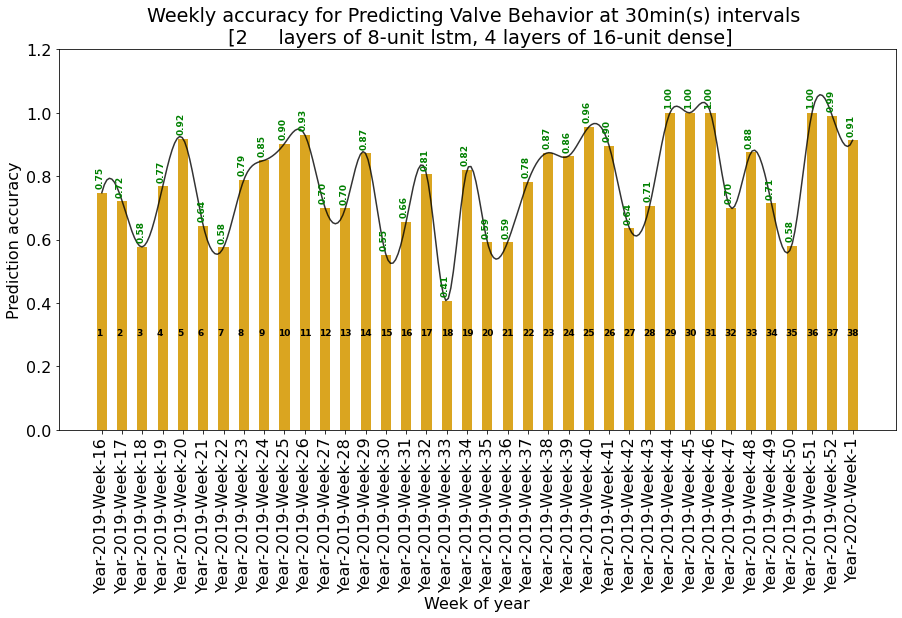

In [24]:
metricname = 'accuracy'

# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}: {} Accuracy={} |{} Precision={} |{} ROC={}'
stats = {
    'Train': {
        'accuracy': [],
        'precision': [],
        'roc': []
    },
    'Test': {
        'accuracy': [],
        'precision': [],
        'roc': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[2]]['accuracy'].append(float(p[3]))
    stats[p[4]]['precision'].append(float(p[5]))
    stats[p[6]]['roc'].append(float(p[7]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
metric_list = stats['Test'][metricname]

#cvrmse_list = [i if i <= 30 else float(np.random.uniform(100,101,1)) for i in cvrmse_list]
#max_cvrmse = max(cvrmse_list)
#cvrmse_list = [i if i <= 30 else (10*(i-30)/(max_cvrmse-30))+30 for i in cvrmse_list]

# from dataprocess import plotutils as pu
plot_args = dict(
    bars=metric_list,
    color='goldenrod',
    bar_label=metricname,
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='Prediction '+metricname,
    title=
    'Weekly {5:} for Predicting Valve Behavior at {4:}min(s) intervals \n [{0:} \
    layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense]'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            5*period,metricname),
    xticklist=xticklist,
    plotwidth=15,
    plotheight=7,
    fontsize=16,
    savetitle=metricname+'plot.png')
pu.classification_bar_plot(**plot_args)


Name of the file:  ../results/hwevalve_model_4/adaptive/30min Results_File.txt


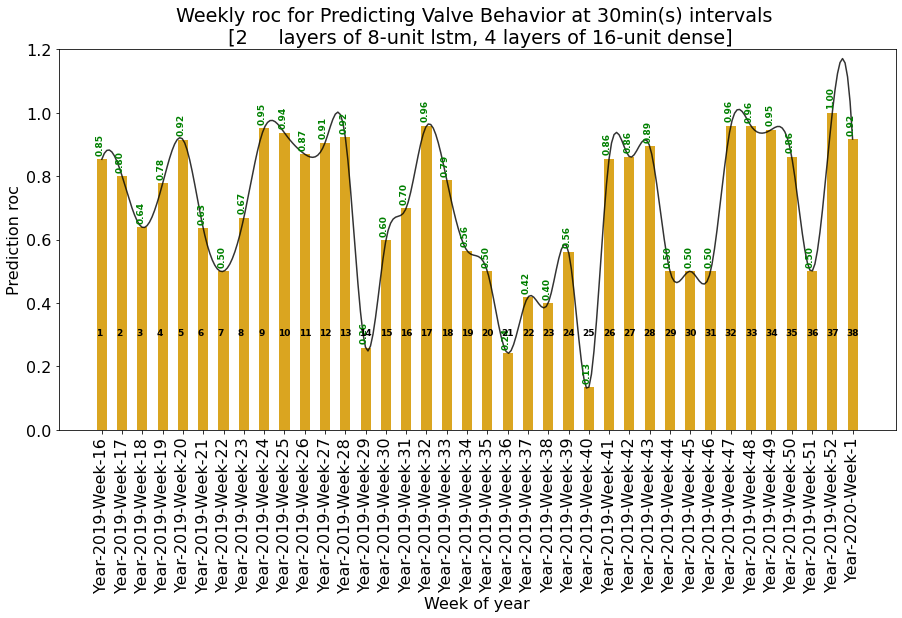

In [25]:
metricname = 'roc'

# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}: {} Accuracy={} |{} Precision={} |{} ROC={}'
stats = {
    'Train': {
        'accuracy': [],
        'precision': [],
        'roc': []
    },
    'Test': {
        'accuracy': [],
        'precision': [],
        'roc': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[2]]['accuracy'].append(float(p[3]))
    stats[p[4]]['precision'].append(float(p[5]))
    stats[p[6]]['roc'].append(float(p[7]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
metric_list = stats['Test'][metricname]

#cvrmse_list = [i if i <= 30 else float(np.random.uniform(100,101,1)) for i in cvrmse_list]
#max_cvrmse = max(cvrmse_list)
#cvrmse_list = [i if i <= 30 else (10*(i-30)/(max_cvrmse-30))+30 for i in cvrmse_list]

# from dataprocess import plotutils as pu
plot_args = dict(
    bars=metric_list,
    color='goldenrod',
    bar_label=metricname,
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='Prediction '+metricname,
    title=
    'Weekly {5:} for Predicting Valve Behavior at {4:}min(s) intervals \n [{0:} \
    layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense]'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            5*period,metricname),
    xticklist=xticklist,
    plotwidth=15,
    plotheight=7,
    fontsize=16,
    savetitle=metricname+'plot.png')
pu.classification_bar_plot(**plot_args)


Name of the file:  ../results/hwevalve_model_4/adaptive/30min Results_File.txt


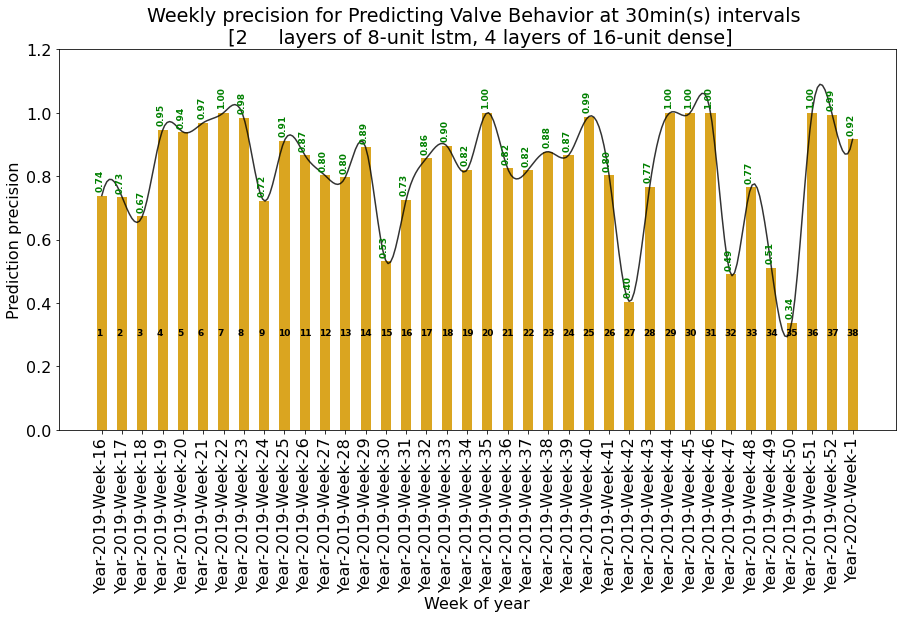

In [26]:
metricname = 'precision'

# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}: {} Accuracy={} |{} Precision={} |{} ROC={}'
stats = {
    'Train': {
        'accuracy': [],
        'precision': [],
        'roc': []
    },
    'Test': {
        'accuracy': [],
        'precision': [],
        'roc': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[2]]['accuracy'].append(float(p[3]))
    stats[p[4]]['precision'].append(float(p[5]))
    stats[p[6]]['roc'].append(float(p[7]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
metric_list = stats['Test'][metricname]

#cvrmse_list = [i if i <= 30 else float(np.random.uniform(100,101,1)) for i in cvrmse_list]
#max_cvrmse = max(cvrmse_list)
#cvrmse_list = [i if i <= 30 else (10*(i-30)/(max_cvrmse-30))+30 for i in cvrmse_list]

# from dataprocess import plotutils as pu
plot_args = dict(
    bars=metric_list,
    color='goldenrod',
    bar_label=metricname,
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='Prediction '+metricname,
    title=
    'Weekly {5:} for Predicting Valve Behavior at {4:}min(s) intervals \n [{0:} \
    layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense]'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            5*period,metricname),
    xticklist=xticklist,
    plotwidth=15,
    plotheight=7,
    fontsize=16,
    savetitle=metricname+' plot.png')
pu.classification_bar_plot(**plot_args)


## Merge the pdfs together

In [27]:
# path where files are stored
pdfs_loc = path + 'detailedplots/'
# list all the files
flist = sorted(
    glob.glob(os.path.join(pdfs_loc, '*'))
)

In [28]:
from PyPDF2 import PdfFileMerger, PdfFileReader
 
# Call the PdfFileMerger
mergedObject = PdfFileMerger()
 
# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for filename in flist:
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
#  Write all the files into a file which is named as shown below
mergedObject.write(path+'DetailedPredvsTarget.pdf')

In [ ]:
#!jupyter nbconvert --to script "Modeling the HX valve and Hot Water Flow operation-Hybrid.ipynb"